# Simulated Annealing (Имитирано закаляване)

<div class="simulated-annealing-algorithm">
    <img src="images/simulated-annealing-algorithm.png" alt="Simulated Annealing" style="width: 700px; margin: 10px;"/>
</div>

### Характеристики:
- вдъхновен от металургията - залаляване на метал
- итеративен алгоритъм
- евристичен (няма доказана сходимост)
- стохастичен (използване на произволни числа)
- MCMC метод (Markov Chain Monte Carlo)

### Параметри:
- **T, Tmin, Tmax** :: температурата е основен параметър, който определя поведението на алгоритъма
    - в началото, когато T е голямо, алгоритъмът прави разходка в ширина (random walk, )
    - към края, когато T е малко, алгоритъмът експлоатира локален екстремум (hill climbing, обхождане в дълбочина)
- **INIT()** - начална точка / начално решение.
- **NEIGHBOUR(T, best)** - дава следваща точка в зависимост от температурата и настоящата най-добра. Например точка от нормалното разпределение около точка **best** с дисперсия **Т**.
<div class="normal">
    <img src="images/normal.png" alt="Normal Distribution" style="width: 400px;"/>
</div>

- **ACCEPT(T, dE)** - определя с каква вероятност ще приемем по-лоша точка.
$$\displaystyle ACCEPT(T, \Delta E) = \mathrm{e}^{\frac{-\Delta E}{kT}}$$
- **ENERGY(X)** - целевата функция, която се оптимизира. При дискретните проблеми трябва да си измислим такава.
- **COOLING(T)** - правилото, по което се намалява температурата **T**
$$COOLING(T) = \alpha T \hspace{2pc} \alpha = 0.99$$

### Поведение:

- Explore $\displaystyle T \to \infty \hspace{1pc} \lim_{T \to \infty} \frac{-\Delta E}{kT} = 0 \hspace{2pc} \mathrm{e}^{0} = 1$

- Exploit $\displaystyle T \to 0 \hspace{1pc} \lim_{T \to 0} \frac{-\Delta E}{kT} = -\infty \hspace{2pc} \mathrm{e}^{-\infty} \to 0$

### Плюсове:
- лесно адаптиране на алгоритъма към даден проблем (непрекъснат или дискретен)
- не налага никакви ограничения върху целевата функция **ENERGY(X)**
    - няма нужда **ENERGY(X)** да е непрекъсната, може и да е **дискретна**
    - не изисква например да е гладка (да има N непрекъснати производни), производната да е Липшицова или Хесиана да е положително полу-дефинитна матрица, както при градиентните методи
    - няма ограничение за изпъкналост (единствен оптимум)
- паралелизъм / последователно пускане на алгоритъма там, където е приключил


### Минуси:
- евристичен, тоест не е гарантирано, че ще намерим оптимум
- не знаем колко близо сме до оптимума


### Марковска верига  

$X_{k-1} (минало) \implies X_k (настояще) \implies X_{k+1} (бъдеще)$

Случаен процес, при който следващото състояние $(X_{k+1})$ зависи само от настоящото състояние $(X_k)$.

Бъдещето не зависи от миналото.

Безпаметен процес.

<div class="markov-chain">
    <img src="images/markov-chain.png" alt="Markov Chain" style="float: left; margin-top: 10px;"/>
</div>

### Монте Карло

- Как бихте намрили обема на пресичащи се неправилни фигури?
- Как бихте интегрирали непрекъсната функция?
    - Квадратурни формули - проклятието на размерността

Обща схема на стратегията:
1. Определяне на ограничена област за интегриране $M$.
2. Генериране на произволни точки околко областта.
3. Изчисляване и агрегиране на резултата. $(S = \frac{inside}{all} \cdot M)$  


- Детерминистичните алгоритми за числено интегриране зависят от размерността. Ако трябва да се оценят 10 точки за 1 измерение, то ще трябва да се оценят $10^{100}$ за 100 измерения. (Има $10^{80}$ във вселената)
- Сходимостта на метода не зависи от размерността на функцията, която интегрираме - $O\left(\frac{1}{\sqrt{N}}\right)$. (според Централната гранична теорема)

<div class="monte-carlo">
    <img src="images/monte-carlo-pi.gif" alt="Monte Carlo" style="width: 500px; float: left; margin-top: 10px;"/>
</div>

In [1]:
import operator
import numpy as np
import math
from numpy import random

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import matplotlib.animation as animation

%matplotlib nbagg

class SimulatedAnnealing():
    def __init__(self, minimize, T_min, T_max, init,
                 neighbour, energy, accept, cooling):
        self.compare = operator.lt if minimize else operator.gt
        self.T_min = T_min
        self.neighbour = neighbour
        self.energy = energy
        self.accept = accept
        self.cooling = cooling
        
        self.T = T_max
        self.best = init()
        self.step = 0

    def iteration(self):
        next = self.neighbour(self.T, self.best)
        deltaE = self.energy(next) - self.energy(self.best)
        if self.compare(deltaE, 0):
            self.best = next
        elif random.random() < self.accept(self.T, deltaE):
            self.best = next

    def cool(self):
        self.T = self.cooling(self.T, self.best)

    def execute(self):
        while self.T > self.T_min:
            self.iteration()
            self.cool()
            self.log()
            self.step += 1
        print('\nf(' + str(self.best) + ') = ' + str(self.energy(self.best)))
        return self.best
    
    def log(self):
        if(self.step % 100 == 0):
            print(str(self.step) + " T="+str(self.T) +
                  "\tf(" + str(self.best) + ") = " + str(self.energy(self.best)))

# standart configuration parameters and functions for Simulated Annealing
t_min = 1e-5
t_max = 1

def init():
    return np.array([0.1, 1.4])

def neighbour(T, x):
    #return x + random.uniform(-T, T, x.shape)
    return random.normal(x, max(T, 0.1), x.shape)

def accept(T, deltaE, k=0.1):
    return math.exp(-(deltaE)/k/T)

def cooling(T, best):
    return T*0.99

<IPython.core.display.Javascript object>


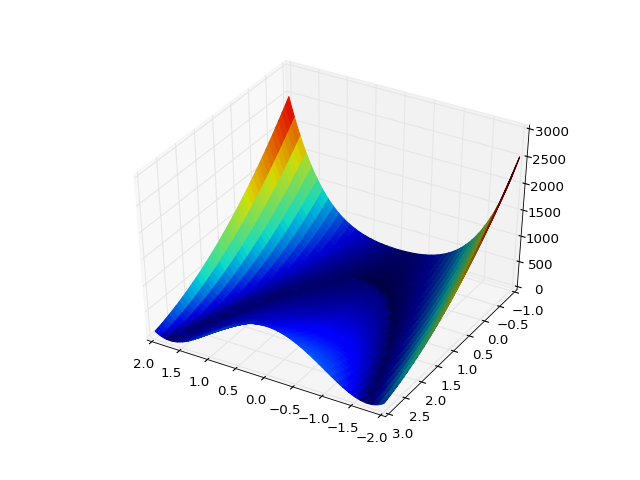

In [2]:
# plot the Rosenbrock function

def rosenbrock(x, y, a=1, b=100):
    return (a - x)**2 + b*(y - x**2)**2

def rosenbrock_energy(vector):
    return rosenbrock(*vector)

# Design variables at mesh points
i1 = np.arange(-2, 2, 0.01)
i2 = np.arange(-1, 3, 0.01)
X, Y = np.meshgrid(i1, i2)
Z = rosenbrock(X, Y)

fig = plt.figure()
ax = plt.axes(projection='3d')

Gx, Gy = np.gradient(Z) # gradients with respect to x and y
G = (Gx**2+Gy**2)**.5  # gradient magnitude
N = G/G.max()  # normalize 0..1

ax.plot_surface(X, Y, Z,facecolors=cm.jet(N))

plt.show()

In [3]:
# minimize the Rosenbrock function with Simulated Annealing

rosenbrock_min = SimulatedAnnealing(True, t_min, t_max, init,
                                    neighbour, rosenbrock_energy, accept, cooling).execute()

0 T=0.99	f([-0.57229144  0.9692082 ]) = 43.6487961158
100 T=0.36237201786049694	f([ 0.40414722  0.15467403]) = 0.362541734991
200 T=0.13263987810938213	f([ 0.56795996  0.29579611]) = 0.25838828448
300 T=0.0485504851305729	f([ 0.85318309  0.74020411]) = 0.0366417466775
400 T=0.017771047742294682	f([ 0.94328305  0.8927049 ]) = 0.00407061100965
500 T=0.006504778211990459	f([ 0.94328305  0.8927049 ]) = 0.00407061100965
600 T=0.0023809591983979563	f([ 0.98645173  0.97690517]) = 0.00164139246353
700 T=0.0008715080698656353	f([ 0.98645173  0.97690517]) = 0.00164139246353
800 T=0.00031900013925143135	f([ 0.98645173  0.97690517]) = 0.00164139246353
900 T=0.00011676436783668758	f([ 1.02459157  1.04729574]) = 0.00122582833924
1000 T=4.2739534936551264e-05	f([ 1.02459157  1.04729574]) = 0.00122582833924
1100 T=1.564405203775484e-05	f([ 1.00239572  1.00405687]) = 6.05437459887e-05

f([ 1.00239572  1.00405687]) = 6.05437459887e-05


In [12]:
# knapsack problem data set generator
DIM = 60
MAX_VALUE = 100000000
MAX_WEIGHT = 100000000
C = 1000000000
W = np.random.randint(MAX_WEIGHT, size=DIM)
V = np.random.randint(MAX_VALUE, size=DIM)
print(W)
print(V)

[50508512 45612874 68995606 51555881  7888806 27717399 89792200 48341687
 81956496 29744506 10243303 67776742  1976422 47919356 68862823 60166775
  6153373 34576885 77361324  2611002  2937994 76623796 15924372  9295204
 12339558 69039205 50810236 28984685 44202307  2502675 43006413 26770828
 54234380  2513437 23312521 19613071 87182625 59932113 99591353 19879702
 28934815 21925296 27453491 97139384 34771529 32841411 52820785 31823335
 61669075 18783370 94897166  7241912 31642946 60867298 87870291 35125843
 67157940 75240814 13550102 93218533]
[19477549 30095130 27347070 73355647 76626791 37981667 49067362 42266889
 93111366 25894584 56296386 39395977  1597402 31284521 19490348 18214462
 71456319 28796189 72944700 97080296 17779108 14873395 40113818 73048597
 48158954 83594637 15656385 65269678 60352863 83582053 42893774 14020881
 28001153 61003924 61159474 48318038 81005760 53278619 16104995 72132366
 98251877 46959308 79030952 74745160 37105453 95903305 89735102 55172946
 38352511 384

In [6]:
# maximization of the 0-1 Knapsack Problem with data taken from
# https://people.sc.fsu.edu/~jburkardt/datasets/knapsack_01/knapsack_01.html

# DIM = 15
# W = [70, 73, 77, 80, 82, 87, 90, 94, 98, 106, 110, 113, 115, 118, 120]
# V = [135, 139, 149, 150, 156, 163, 173, 184, 192, 201, 210, 214, 221, 229, 240]
# C = 750
# OPTIMUM = 1458
# OPTIMAL_KNAPSACK = [1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1]

DIM = 24
W = [382745, 799601, 909247, 729069, 467902, 44328, 34610, 698150,
     823460, 903959, 853665, 551830, 610856, 670702, 488960, 951111,
     323046, 446298, 931161, 31385, 496951, 264724, 224916, 169684]
V = [825594, 1677009, 1676628, 1523970, 943972, 97426, 69666, 1296457,
     1679693, 1902996, 1844992, 1049289, 1252836, 1319836, 953277,
     2067538, 675367, 853655, 1826027, 65731, 901489, 577243, 466257, 369261]
C = 6404180
OPTIMUM = 13549094
OPTIMAL_KNAPSACK = [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1]


def kp_init():
    return np.random.randint(2, size=DIM)

def kp_neighbour(T, knapsack):
    new_knapsack = np.copy(knapsack)
    new_knapsack[random.randint(DIM)] ^= 1
    while kp_cost(new_knapsack) == 0:
        new_knapsack[random.randint(DIM)] ^= 1
    return new_knapsack

def kp_cost(knapsack):
    total_weight = sum([W[i] for i, chosen in enumerate(knapsack) if chosen])
    total_value = sum([V[i] for i, chosen in enumerate(knapsack) if chosen])
    return 0 if total_weight > C else total_value

def kp_accept(T, deltaE, k=0.1):
    return math.exp(deltaE / k / T)

kp_max = SimulatedAnnealing(False, t_min, t_max, kp_init,
                            kp_neighbour, kp_cost, kp_accept, cooling).execute()

mismatches = 0
for i, item in enumerate(kp_max):
    mismatches += 1 if kp_max[i] != OPTIMAL_KNAPSACK[i] else 0
print(str(mismatches) + " items in the selection mismatch with the optimal solution")
print("{0:.3f}% less optimal then the most optimal solution".format((1 - kp_cost(kp_max)/OPTIMUM) * 100))

0 T=0.99	f([1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 0 1 0 0]) = 11279669
100 T=0.36237201786049694	f([0 1 0 1 0 1 1 1 1 0 1 1 1 0 0 1 0 0 0 1 0 1 0 0]) = 13201850
200 T=0.13263987810938213	f([1 1 1 1 0 1 1 0 1 0 1 0 0 0 0 1 1 0 0 1 0 1 1 0]) = 13247114
300 T=0.0485504851305729	f([1 1 1 1 0 1 1 0 1 0 1 0 0 0 0 1 1 0 0 1 0 1 1 0]) = 13247114
400 T=0.017771047742294682	f([1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0]) = 13264151
500 T=0.006504778211990459	f([1 1 0 1 1 0 0 0 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0]) = 13385150
600 T=0.0023809591983979563	f([1 1 0 1 1 0 0 0 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0]) = 13385150
700 T=0.0008715080698656353	f([1 1 0 1 1 0 1 0 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0]) = 13389085
800 T=0.00031900013925143135	f([1 1 0 1 1 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 1]) = 13521334
900 T=0.00011676436783668758	f([1 1 0 1 1 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 1]) = 13521334
1000 T=4.2739534936551264e-05	f([1 1 0 1 1 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 1]) = 13521334
1100 T=1.564

<IPython.core.display.Javascript object>


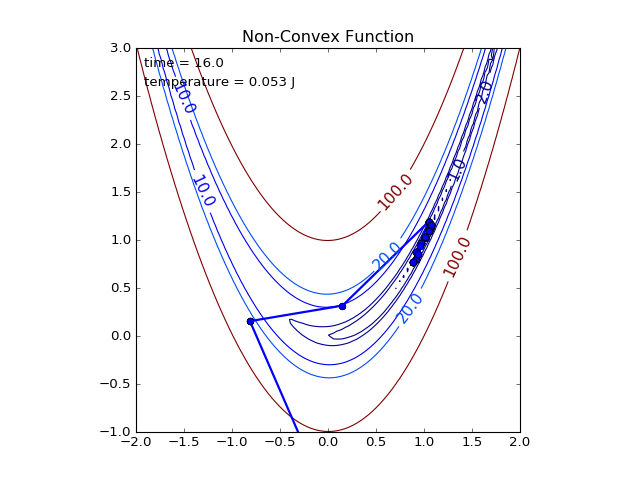

In [5]:
# animation of Rosenbrock minimization

sa = SimulatedAnnealing(True, t_min, t_max, init, neighbour, rosenbrock_energy, accept, cooling)
fig = plt.figure()
xmin, xmax = -2.0, 2.0
ymin, ymax = -1.0, 3.0
x1 = np.linspace(xmin, xmax, 100)
x2 = np.linspace(ymin, ymax, 100)
Xc, Yc = np.meshgrid(x1, x2)
Zc = rosenbrock(Xc, Yc)
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False, xlim=(xmin, xmax), ylim=(ymin, ymax))
CS = ax.contour(Xc, Yc, Zc, levels=[0, 0.1, 1, 2, 10, 20, 100])
ax.clabel(CS, inline=1, fmt='%1.1f', fontsize=14)
ax.set_title('Non-Convex Function')
line, = ax.plot([], [], 'o-', lw=2)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
energy_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)

def init_animation():
    line.set_data([], [])
    time_text.set_text('')
    energy_text.set_text('')
    return line, time_text, energy_text

xs = []
ys = []
def animate(step):
    global sa, xs, ys
    sa.iteration()
    sa.cool()
    xs.append(sa.best[0])
    ys.append(sa.best[1])
    line.set_data(xs, ys)
    time_text.set_text('time = %.1f' % step)
    energy_text.set_text('temperature = %.3f J' % sa.T)
    return line, time_text, energy_text

ani = animation.FuncAnimation(fig, animate, frames=25, interval=25, init_func=init_animation)
plt.show()

<IPython.core.display.Javascript object>


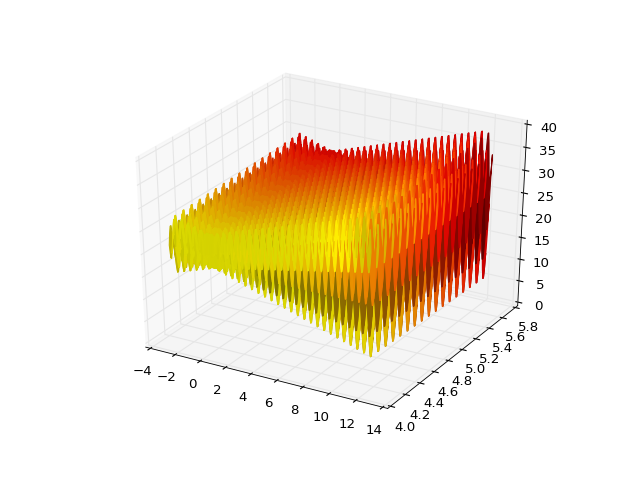

In [7]:
def spike_pit(x, y):
    return 21.5 + x*np.sin(4*math.pi*x) + y*np.sin(20*math.pi*y)

xs = np.arange(-3, 12.1, 0.01)
ys = np.arange(4.1, 5.8, 0.01)
# xs = np.arange(10, 40, 0.01)
# ys = np.arange(-10, 10, 0.01)

X, Y = np.meshgrid(xs, ys)
Z = spike_pit(X, Y)

fig = plt.figure()
ax = plt.axes(projection='3d')

Gx, Gy = np.gradient(Z) # gradients with respect to x and y
G = (Gx**2+Gy**2)**.5  # gradient magnitude
N = G/G.max()  # normalize 0..1

ax.plot_surface(X, Y, Z,facecolors=cm.jet(N))
# ax.plot_surface(X, Y, Z)

plt.show()

In [8]:
# minimize the spike pit
# https://www.wolframalpha.com/input/?i=minimize+21.5+%2B+x*sin(4*pi*x)+%2B+y*sin(20*pi*y)

def spike_init():
    return np.array([30.0, 0.0])

def spike_energy(vector):
    return spike_pit(*vector)

spike_pit_min = SimulatedAnnealing(False, t_min, t_max, spike_init,
                                   neighbour, spike_energy, kp_accept, cooling).execute()

0 T=0.99	f([ 30.   0.]) = 21.5
100 T=0.36237201786049694	f([ 33.62461932   0.52057694]) = 55.6248375818
200 T=0.13263987810938213	f([ 33.62098922   0.92711583]) = 55.9972305327
300 T=0.0485504851305729	f([ 33.62098922   0.92711583]) = 55.9972305327
400 T=0.017771047742294682	f([ 33.62098922   0.92711583]) = 55.9972305327
500 T=0.006504778211990459	f([ 33.62098922   0.92711583]) = 55.9972305327
600 T=0.0023809591983979563	f([ 33.62211105   1.0274643 ]) = 56.1151298899
700 T=0.0008715080698656353	f([ 33.62211105   1.0274643 ]) = 56.1151298899
800 T=0.00031900013925143135	f([ 33.62211105   1.0274643 ]) = 56.1151298899
900 T=0.00011676436783668758	f([ 33.62211105   1.0274643 ]) = 56.1151298899
1000 T=4.2739534936551264e-05	f([ 33.62211105   1.0274643 ]) = 56.1151298899
1100 T=1.564405203775484e-05	f([ 33.62211105   1.0274643 ]) = 56.1151298899

f([ 33.62211105   1.0274643 ]) = 56.1151298899


<IPython.core.display.Javascript object>


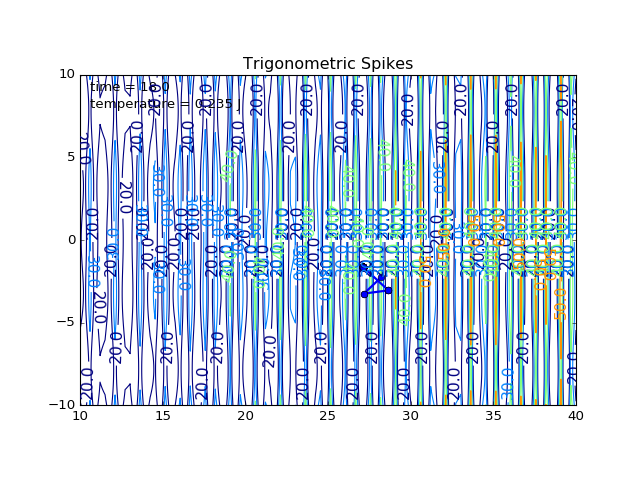

In [9]:
# animation of Spike Pit maximization

sa = SimulatedAnnealing(False, t_min, t_max, spike_init,
                                   neighbour, spike_energy, kp_accept, cooling)
fig = plt.figure()
xmin, xmax = 10, 40
ymin, ymax = -10, 10
x1 = np.linspace(xmin, xmax, 100)
x2 = np.linspace(ymin, ymax, 100)
Xc, Yc = np.meshgrid(x1, x2)
Zc = spike_pit(Xc, Yc)
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False, xlim=(xmin, xmax), ylim=(ymin, ymax))
CS = ax.contour(Xc, Yc, Zc, levels=[20, 30, 40, 50, 60])
ax.clabel(CS, inline=1, fmt='%1.1f', fontsize=14)
ax.set_title('Trigonometric Spikes')
line, = ax.plot([], [], 'o-', lw=2)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
energy_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)

def init_animation():
    line.set_data([], [])
    time_text.set_text('')
    energy_text.set_text('')
    return line, time_text, energy_text

xs = []
ys = []
def animate(step):
    global sa, xs, ys
    sa.iteration()
    sa.cool()
    sa.log()
    sa.step += 1
    xs.append(sa.best[0])
    ys.append(sa.best[1])
    line.set_data(xs, ys)
    time_text.set_text('time = %.1f' % step)
    energy_text.set_text('temperature = %.3f J' % sa.T)
    return line, time_text, energy_text

ani = animation.FuncAnimation(fig, animate, frames=25, interval=25, init_func=init_animation)
plt.show()